## CAB PRICE PREDICTION
---

### Problem Statement

Uber and Lyft's ride prices are not constant like public transport. They are greatly affected by the demand and supply of rides at a given time. So, what exactly drives this demand? The first guess would be the time of the day; times around 9 am and 5 pm should see the highest surges on account of people commuting to work/home. Another guess would be the weather; rain/snow/hotness/humidity should cause more people to take rides.
Our aim is to try to analyze the prices of these ride-sharing apps and try to figure out what factors are driving the demand. Do Mondays have more demand than Sunday at 9 am? Do people avoid cabs on a sunny day? Was there a Red Sox match at Fenway that caused more people coming in? 

### Data

With no public data of rides/prices shared by any entity, we have used a comprehensive dataset found on [Kaggle](https://www.kaggle.com/brllrb/uber-and-lyft-dataset-boston-ma) which comprises of the actual cab prices data and corresponding weather conditions
The Cab ride data covers various types of cabs for Uber & Lyft and their price for the given location. You can also find if there was any surge in the price during that time. Weather data contains weather attributes like temperature, rain, cloud, etc. for all the locations taken into consideration.

### Use cases

- Lyft Price Prediction
- Uber Price Prediction


Before we jump on to selecting best features and building our model on top of it, lets perform exploratory data analysis to get some insight into the data.

### Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
cab_df = pd.read_csv('cab.csv')

In [3]:
cab_df.shape

(693071, 57)

We have 57 variables that account for both: the actual cab prices data and corresponding weather conditions. Let's see what we have...

In [4]:
cab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
id                             693071 non-null object
timestamp                      693071 non-null float64
hour                           693071 non-null int64
day                            693071 non-null int64
month                          693071 non-null int64
datetime                       693071 non-null object
timezone                       693071 non-null object
source                         693071 non-null object
destination                    693071 non-null object
cab_type                       693071 non-null object
product_id                     693071 non-null object
name                           693071 non-null object
price                          637976 non-null float64
distance                       693071 non-null float64
surge_multiplier               693071 non-null float64
latitude                       693071 non-null float64
longitude              

In [5]:
cab_df.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


Lets check data for NaNs and if present Impute them with mean values for that column! 

In [6]:
cab_df.isnull().sum()

id                                 0
timestamp                          0
hour                               0
day                                0
month                              0
datetime                           0
timezone                           0
source                             0
destination                        0
cab_type                           0
product_id                         0
name                               0
price                          55095
distance                           0
surge_multiplier                   0
latitude                           0
longitude                          0
temperature                        0
apparentTemperature                0
short_summary                      0
long_summary                       0
precipIntensity                    0
precipProbability                  0
humidity                           0
windSpeed                          0
windGust                           0
windGustTime                       0
v

In [7]:
from sklearn.preprocessing import Imputer

imp1 = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imp1 = imp1.fit(cab_df.iloc[:, [12]].values)
cab_df.iloc[:, [12]] = imp1.transform(cab_df.iloc[:, [12]].values)

The dataframe has a variable called **'short_summary'** that summarizes the weather on that particular day. The values of the variable are somewhat similar and we don't need both of them to exist (since they convey similar summary) i.e. **Light rain, Rain, Possible Drizzle & Drizzle** all means that it was rainy. Hence, we define a function that labels the data on a less granular level which makes it easy for us to visualize it. 

In [8]:
cab_df.short_summary.unique()

array([' Mostly Cloudy ', ' Rain ', ' Clear ', ' Partly Cloudy ',
       ' Overcast ', ' Light Rain ', ' Foggy ', ' Possible Drizzle ',
       ' Drizzle '], dtype=object)

In [9]:
def get_weather_condition(weather):
    if ((' Light Rain ' == weather) or  (' Rain ' == weather) or  
        (' Possible Drizzle ' == weather) or (' Drizzle ' == weather)):
        return 'Rainy'
    elif ((' Mostly Cloudy ' == weather) or (' Mostly Cloudy ' == weather) or (' Partly Cloudy ' == weather) or 
          (' Overcast '== weather) or (' Foggy ' == weather)):
        return 'Cloudy'
    else:
        return 'Clear'

weather_list = []
for weather in cab_df.short_summary:
    weather_list.append(get_weather_condition(weather))

cab_df['weather'] = weather_list

In [10]:
cab_df.weather.unique()

array(['Cloudy', 'Rainy', 'Clear'], dtype=object)

So now we have 3 distinct values as opposed to 9! 

### Uber vs Lyft?

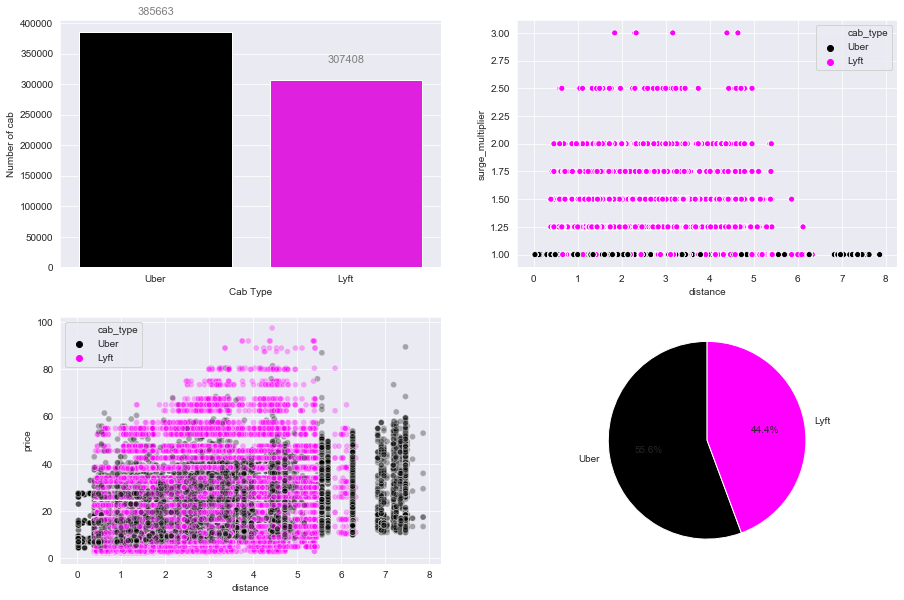

In [11]:
sns.set_style('darkgrid')
f, axes = plt.subplots (2,2, figsize=(15,10))

#setting color scheme to our plots 
color_codes = {"Uber" : "black", "Lyft": "fuchsia"}

#histogram
x=['Uber','Lyft']
y = [cab_df.cab_type[(cab_df.cab_type)=='Uber'].count(),\
     cab_df.cab_type[(cab_df.cab_type)=='Lyft'].count()]

vis1= sns.barplot(x,y,ax=axes[0][0],palette=color_codes)
vis1.set(xlabel='Cab Type',ylabel='Number of cab')


for p in vis1.patches:
    vis1.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
        
         
#Pie
Ncab_type = [cab_df.cab_type[(cab_df.cab_type)=='Uber'].count(),\
             cab_df.cab_type[(cab_df.cab_type)=='Lyft'].count()]
     
cab_type = ['Uber','Lyft']

plt.pie(Ncab_type, labels=color_codes, startangle=90, autopct='%.1f%%',colors=color_codes.values())


#ScatterPlot distance vs Price
Taxi=cab_df[cab_df.name == 'Taxi'].index
cab_df.drop(Taxi , inplace=True)
vis2=sns.scatterplot(x=cab_df.distance,y=cab_df.price,data=cab_df, hue=cab_df.cab_type, hue_order=cab_type,alpha=0.3, legend='full',ax=axes[1][0],palette=color_codes)

#ScatterPlot distance vs surge_multiplier
vis3=sns.scatterplot(x=cab_df.distance,y=cab_df.surge_multiplier,data=cab_df, hue=cab_df.cab_type, hue_order=cab_type,ax=axes[0][1],palette=color_codes)

plt.show()


Before showing a general **price vs distance chart**, we drop **'Taxi'** from Uber cabs as they use a different fare structure (in the dataset Taxi fare is always 0 USD) Based on the chart above, it can be observed that:

- **Lyft has a lower minimum fare compared to Uber, at the same time Lyft has higher maximum fare.** 
- **Uber travel distances are generally higher than Lyft.**

We also know there is a **'surge multiplier'** factor in Lyft, where the fare is multiplied by a certain rate during rush hours.

When prices surge , Uber does not show a multiplier and instead quotes only the higher price up front. Lyft marks up its Prime Time pricing with a percentage: If the rate is 50 percent, a fare that would normally be $10 costs $15. 

### Surge trend Investigation

In [12]:
lyft=cab_df[cab_df.cab_type == 'Lyft'].groupby(['name','surge_multiplier'],as_index=False).count()
lyft[['name','surge_multiplier']]

,name,surge_multiplier
0,Lux,1.00
1,Lux,1.25
2,Lux,1.50
3,Lux,1.75
4,Lux,2.00
5,Lux Black,1.00
6,Lux Black,1.25
7,Lux Black,1.50
8,Lux Black,1.75
9,Lux Black,2.00


Except "Shared" type Lyft, most of the Lyft cabs shows a similar number of "surge multiplier" occurence. Chart below will show a rough idea on the occurence rate. 

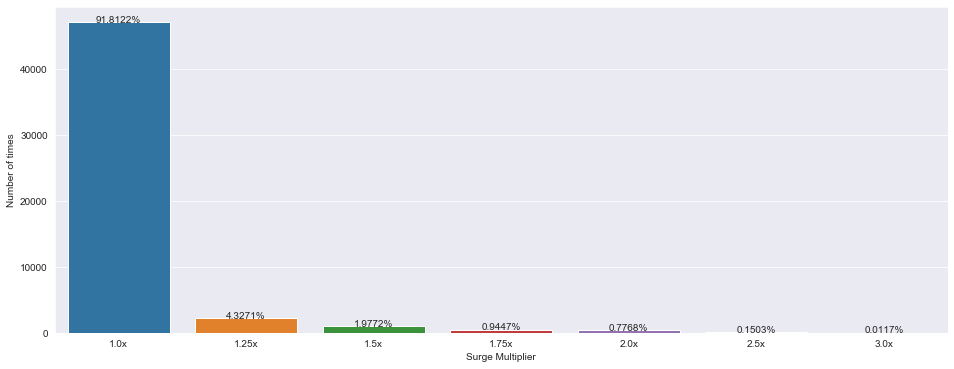

In [13]:
plt.figure(figsize=(16, 6))

sns.set_style('darkgrid')
Surge=lyft[22:29]['id']

Surge_Factor = ['1.0x','1.25x','1.5x','1.75x','2.0x','2.5x','3.0x']

vis1= sns.barplot(x=Surge_Factor,y=Surge)
vis1.set(xlabel='Surge Multiplier',ylabel='Number of times')

total=sum(Surge/100)
for p in vis1.patches:
    height = p.get_height()
    vis1.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:1.4f}%'.format(height/total),
              ha="center") 

plt.show()

We observe that:
- **92% of the time, surge does not happen**
- **4% of the time, 1.25x surge multiplier happens to the fare**
- **2% of the time, for 1.5x surge multiplier and so on**

In this case, we will multiply the surge multiplier to the initial estimated fare, to show the actual price for Lyft rides.

In [14]:
#creating a separate df to calulcate actual prices (price*surge_multiplier)
df2=cab_df.copy()

for i in (list(df2.index.values)):
    if df2.cab_type[i]=='Uber': 
        pass
    elif (df2.cab_type[i]=='Lyft') & (df2.surge_multiplier[i]!=1.0):
        df2.price[i]=(cab_df.price[i] * df2.surge_multiplier[i])

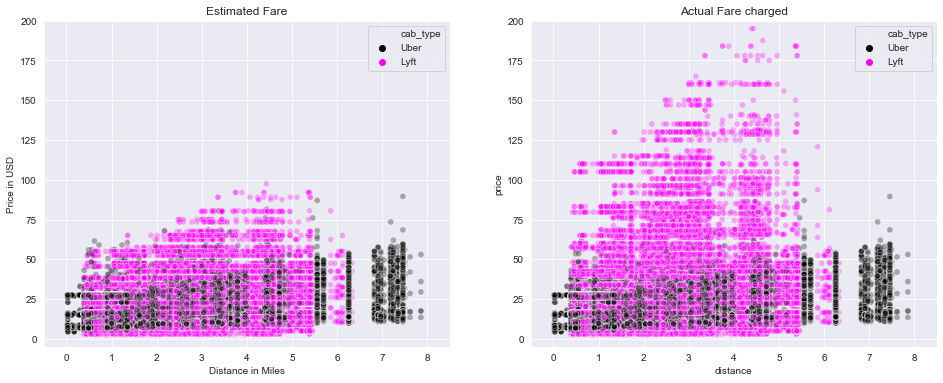

In [15]:
g, axes = plt.subplots (1,2, figsize=(16,6))

sns.set_style('darkgrid')

vis1=sns.scatterplot(x=cab_df.distance,
                     y=cab_df.price,
                     data=cab_df, 
                     hue=cab_df.cab_type, 
                     hue_order=cab_type,
                     alpha=0.3, 
                     ax=axes[0],
                     palette=color_codes)

vis2=sns.scatterplot(x=df2.distance,
                     y=df2.price,data=df2, 
                     hue=df2.cab_type, 
                     hue_order=cab_type, 
                     alpha=0.3,ax=axes[1],
                     palette=color_codes)

vis1.set(xlim=(-0.5, 8.5))
vis1.set(ylim=(-5, 200))
vis2.set(xlim=(-0.5, 8.5))
vis2.set(ylim=(-5, 200))
vis1.set(xlabel='Distance in Miles',ylabel='Price in USD')
#vis1.set(xlabel='Distance in Miles',ylabel='Price in USD')


axes[0].set_title('Estimated Fare')
axes[1].set_title('Actual Fare charged')

plt.ioff()

After multiplying with the surge multiplier, Lyft fare shows higher range of fare. Does this means Uber has a better fare rate? The answer is No. We'll prove it in the coming visualizations. First, let's break down into the types of rides both companies have. As we know there are normal rides, carpool rides, SUV rides, luxury rides etc....each has a different rate.

### Fare vs Distance

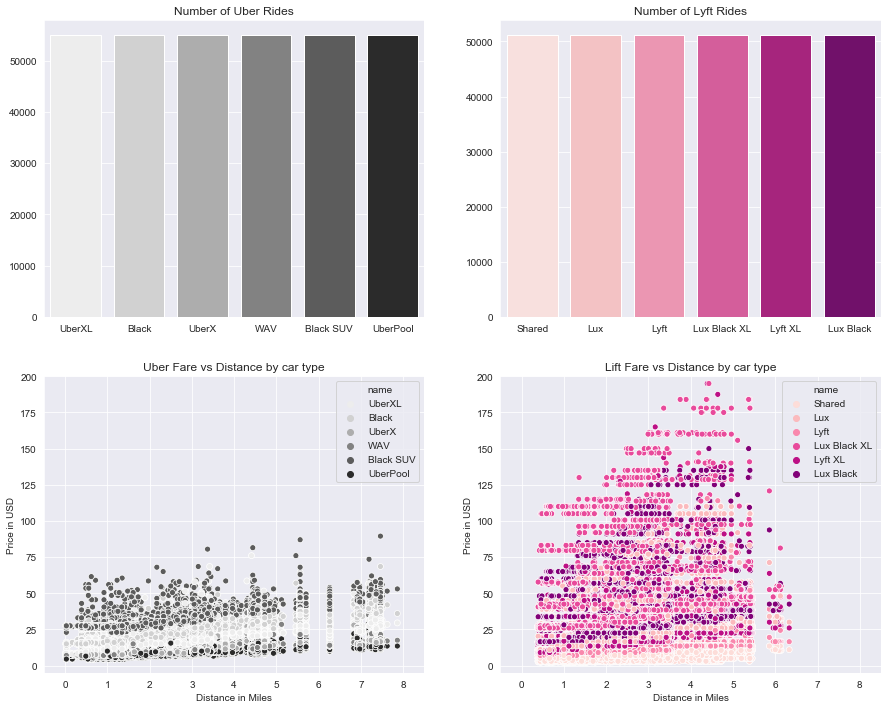

In [16]:
h, axes = plt.subplots (2,2, figsize=(15,12))

sns.set_style('darkgrid')

Ux=cab_df.name[cab_df.cab_type=='Uber'].unique()
Lx=cab_df.name[cab_df.cab_type=='Lyft'].unique()

Uy = cab_df.name[cab_df.name=='UberXL'].count(),cab_df.name[cab_df.name=='Black'].count(),\
     cab_df.name[cab_df.name=='UberX'].count(),cab_df.name[cab_df.name=='WAV'].count(),\
     cab_df.name[cab_df.name=='Black SUV'].count(),cab_df.name[cab_df.name=='UberPool'].count()

Ly=cab_df.name[cab_df.name=='Shared'].count(),cab_df.name[cab_df.name=='Lux'].count(),\
     cab_df.name[cab_df.name=='Lyft'].count(),cab_df.name[cab_df.name=='Lux Black XL'].count(),\
     cab_df.name[cab_df.name=='Lyft XL'].count(),cab_df.name[cab_df.name=='Lux Black'].count()

vis1= sns.barplot(Ux,Uy,palette='Greys',ax=axes[0][0])
vis2= sns.barplot(Lx,Ly,palette='RdPu',ax=axes[0][1])

axes[0][0].set_title('Number of Uber Rides')
axes[0][1].set_title('Number of Lyft Rides')


Lyft2=df2[df2.cab_type == 'Lyft']
Uber=df2[df2.cab_type == 'Uber']


vis3=sns.scatterplot(x=Lyft2.distance, y=Lyft2.price,data=Lyft2, palette="RdPu",hue=Lyft2.name, ax=axes[1][1])
vis4=sns.scatterplot(x=Uber.distance, y=Uber.price,data=Uber, palette="Greys" , hue=Uber.name, ax=axes[1][0])

vis3.set(xlim=(-0.5, 8.5))
vis3.set(ylim=(-5, 200))
vis4.set(xlim=(-0.5, 8.5))
vis4.set(ylim=(-5, 200))
vis3.set(xlabel='Distance in Miles',ylabel='Price in USD')
vis4.set(xlabel='Distance in Miles',ylabel='Price in USD')


axes[1][1].set_title('Lift Fare vs Distance by car type')
axes[1][0].set_title('Uber Fare vs Distance by car type')

plt.ioff()

In [17]:
print("Uber Average Prices Per Category : \n {0} \n \nLyft Average Price Per Category :  \n {1} \n ".format(cab_df[(cab_df.cab_type == 'Uber')][['name','price']].groupby('name').mean(),cab_df[(cab_df.cab_type == 'Lyft')][['name','price']].groupby('name').mean()))

Uber Average Prices Per Category : 
                price
name                
Black      20.523786
Black SUV  30.286763
UberPool    8.752500
UberX       9.765074
UberXL     15.678144
WAV         9.765019 
 
Lyft Average Price Per Category :  
                   price
name                   
Lux           17.771240
Lux Black     23.062468
Lux Black XL  32.324086
Lyft           9.610885
Lyft XL       15.309363
Shared         6.029893 
 


The dataset has equal number of ride types for both company, with Uber having roughly 5000 more rides than Lyft for each category. 

Unfortunately the chart looks a little messy and it is difficult to compare, so let's further break down the types of rides. Based on some online results, we can say the following for both competiting company rides:

Lyft vs Uber
- **Lyft ordinary ride fare is comparable to UberX**
- **Lux Black XL is comparable to Black SUV**
- **Lyft XL is comparable to UberXL**
- **Shared is comparable to UberPool**
    
At the same time, we will join the intersection of Lyft and Uber rides that shares the same time frame (timestamp) and source & destination. This way it is a fair comparison as we are comparing the exact time/weather/traffic condition from both company.

Further drop other rides that are hard to compare: WAV= wheelchar accessible (Uber) that is not specified in Lyft. Also,Uber Black which we are not sure to compare with Lyft Lux or Lyft Lux Black

In [18]:
Join_TDS=Uber.merge(Lyft2, how='inner',on=['timestamp','destination','source'])

In [19]:
Join_TDS = Join_TDS.drop(columns=["id_x","product_id_x","id_y","product_id_y","surge_multiplier_x","surge_multiplier_y"])

In [20]:
A=Join_TDS[Join_TDS.name_x == 'WAV'].index
Join_TDS.drop(A , inplace=True)

A=Join_TDS[Join_TDS.name_x == 'Black'].index
Join_TDS.drop(A , inplace=True)

A=Join_TDS[Join_TDS.name_y == 'Lux'].index                
Join_TDS.drop(A , inplace=True)

A=Join_TDS[Join_TDS.name_y == 'Lux Black'].index                
Join_TDS.drop(A , inplace=True)

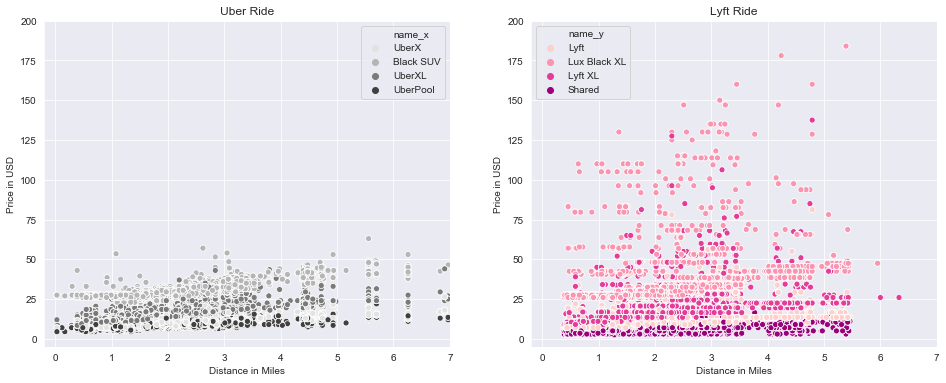

In [21]:
g, axes = plt.subplots (1,2, figsize=(16,6))

sns.set_style('darkgrid')

U1=['UberX','Black SUV','UberXL','UberPool']
L1=['Lyft','Lux Black XL','Lyft XL','Shared']

vis1=sns.scatterplot(x=Join_TDS.distance_x,y=Join_TDS.price_x,data=Join_TDS,hue='name_x',hue_order=U1,ax=axes[0],palette='Greys')
vis2=sns.scatterplot(x=Join_TDS.distance_y,y=Join_TDS.price_y,data=Join_TDS,hue='name_y',hue_order=L1,ax=axes[1],palette='RdPu')

vis1.set(xlim=(-0.2, 7))
vis1.set(ylim=(-5, 200))
vis2.set(xlim=(-0.2, 7))
vis2.set(ylim=(-5, 200))
vis1.set(xlabel='Distance in Miles',ylabel='Price in USD')
vis2.set(xlabel='Distance in Miles',ylabel='Price in USD')
vis1.set_title('Uber Ride')
vis2.set_title('Lyft Ride')

plt.ioff()

It looks like our first observation still stands, Lyft has a bigger range of fare rate, at the same time lower minumum charge. Let's zoom both chart to the majority data located, which is price below $50

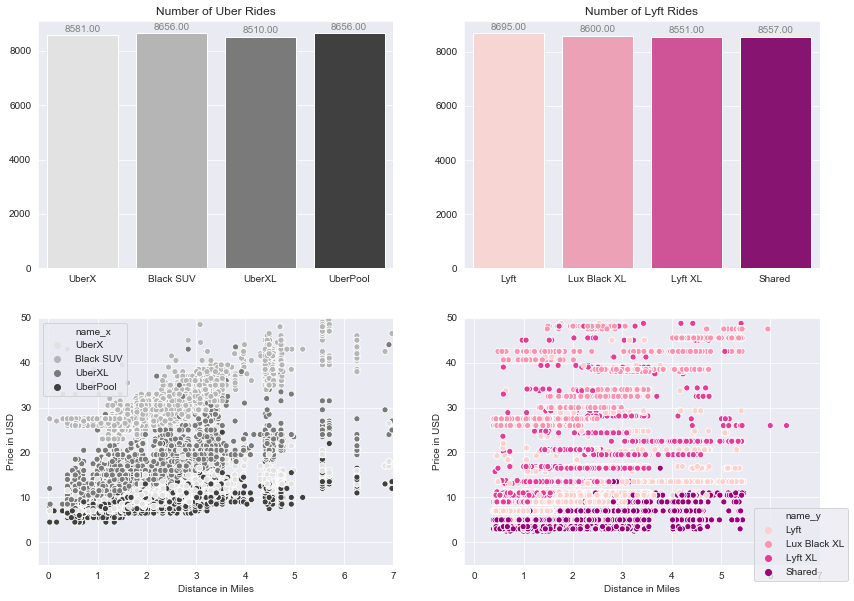

In [22]:
sns.set_style('darkgrid')
g, axes = plt.subplots (2,2, figsize=(14,10))


U1=['UberX','Black SUV','UberXL','UberPool']
L1=['Lyft','Lux Black XL','Lyft XL','Shared']

vis1=sns.scatterplot(x=Join_TDS.distance_x,y=Join_TDS.price_x,data=Join_TDS,hue='name_x',hue_order=U1,ax=axes[1,0],palette='Greys')
vis2=sns.scatterplot(x=Join_TDS.distance_y,y=Join_TDS.price_y,data=Join_TDS,hue='name_y',hue_order=L1,ax=axes[1,1],palette='RdPu')

vis1.set(xlim=(-0.2, 7))
vis1.set(ylim=(-5, 50))
vis2.set(xlim=(-0.2, 7))
vis2.set(ylim=(-5, 50))
vis1.set(xlabel='Distance in Miles',ylabel='Price in USD')
vis2.set(xlabel='Distance in Miles',ylabel='Price in USD')

Ux=['UberX', 'Black SUV', 'UberXL', 'UberPool']
Lx=['Lyft', 'Lux Black XL', 'Lyft XL', 'Shared']

Uy = Join_TDS.name_x[Join_TDS.name_x=='UberX'].count(),Join_TDS.name_x[Join_TDS.name_x=='Black SUV'].count(),\
     Join_TDS.name_x[Join_TDS.name_x=='UberXL'].count(),Join_TDS.name_x[Join_TDS.name_x=='UberPool'].count()

Ly=Join_TDS.name_y[Join_TDS.name_y=='Lyft'].count(),Join_TDS.name_y[Join_TDS.name_y=='Lux Black XL'].count(),\
     Join_TDS.name_y[Join_TDS.name_y=='Lyft XL'].count(),Join_TDS.name_y[Join_TDS.name_y=='Shared'].count()

vis3= sns.barplot(Ux,Uy,ax=axes[0,0],palette='Greys')

vis4= sns.barplot(Lx,Ly,ax=axes[0,1],palette='RdPu')

for p in vis3.patches:
             vis3.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='gray', xytext=(0, 6),
                 textcoords='offset points')
for p in vis4.patches:
             vis4.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='gray', xytext=(0, 6),
                 textcoords='offset points')
        
plt.ioff()


axes[0,0].set_title('Number of Uber Rides')
axes[0,1].set_title('Number of Lyft Rides')
plt.ioff()


plt.legend(bbox_to_anchor=(0.8,0.25))

plt.ioff()


For shared ride ("Shared" for Lyft and "Uberpool' for Uber), Lyft has a cheaper rate compared to Uber. For other rides, both sides looks similar pretty similar and it is difficult to tell which one is cheaper yet. So, a boxplot of price per mile travelled vs ride type is plotted:

In [23]:
list(Join_TDS.columns.values)
A = Join_TDS[['timestamp',
 'destination','source',
'distance_x', 'cab_type_x', 'price_x', 'name_x']]

A.columns=['timestamp',
 'destination','source',
'distance', 'cab_type', 'price', 'name']

B = Join_TDS[['timestamp',
 'destination','source',
'distance_y', 'cab_type_y', 'price_y', 'name_y']]

B.columns=['timestamp',
 'destination','source',
'distance', 'cab_type', 'price', 'name']

FPM=A.append(B)

In [24]:
FPM['fare_per_mile']= round(FPM.price/FPM.distance,2)

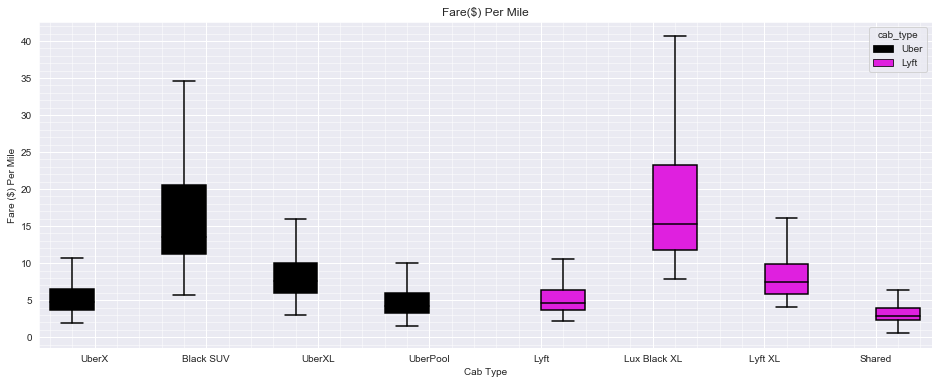

In [25]:
O1=['UberX', 'Black SUV', 'UberXL', 'UberPool', 'Lyft', 'Lux Black XL',
        'Lyft XL','Shared']

import matplotlib as mpl
sns.set_style('darkgrid')
plt.figure(figsize=(16, 6))

vis1 = sns.boxplot( data = FPM, x = 'name', y = 'fare_per_mile', \
                   showfliers=False, hue='cab_type',order=O1,palette=color_codes)


vis1.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
vis1.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

vis1.set_title('Fare($) Per Mile')
vis1.set(xlabel='Cab Type',ylabel='Fare ($) Per Mile')

vis1.grid(b=True, which='major', color='w', linewidth=1)
vis1.grid(b=True, which='minor', color='w', linewidth=0.5)
plt.ioff()

Lyft has a better rate for carpool category. Lyft XL has a slightly lower fare per mile than UberXL. Uber Black SUV shows lower rate than Lyft Black XL. Lyft ordinary ride and UberX has similar rates, in which Lyft is better up till 3rd quarter of sample.

Next let's look at the time factor that might affect the availability and fare for the rides

### Will my ride cost less if I skip the rush hours?

In [26]:
import datetime
df2['fare_per_mile']= round(df2.price/df2.distance,2)

#drop unwanted rows that is not comparable
A=df2[df2.name == 'WAV'].index
df2.drop(A , inplace=True)
A=df2[df2.name == 'Black'].index
df2.drop(A , inplace=True)
A=df2[df2.name == 'Lux'].index                
df2.drop(A , inplace=True)
A=df2[df2.name == 'Lux Black'].index                
df2.drop(A , inplace=True)

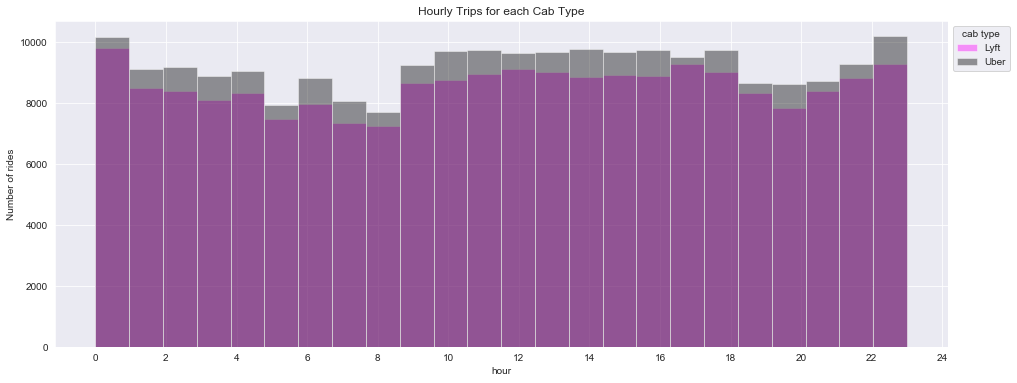

In [27]:
LyftOnly=df2[df2.cab_type == 'Lyft']
UberOnly=df2[df2.cab_type == 'Uber']

f, axes = plt.subplots (figsize=(16,6))

vis1 = sns.distplot(LyftOnly.hour, bins=24,kde=False, color='fuchsia')
vis2 = sns.distplot(UberOnly.hour, bins=24,kde=False,color='black')

plt.xticks(range(0, 25,2))
plt.legend(title='cab type', loc='upper left', labels=['Lyft','Uber'],bbox_to_anchor=(1,1))
vis1.set(ylabel='Number of rides')
axes.set_title('Hourly Trips for each Cab Type')


plt.ioff()

From the distribution we can say that the trend of rides are similar for both company, with Uber having more rides than Lyft.

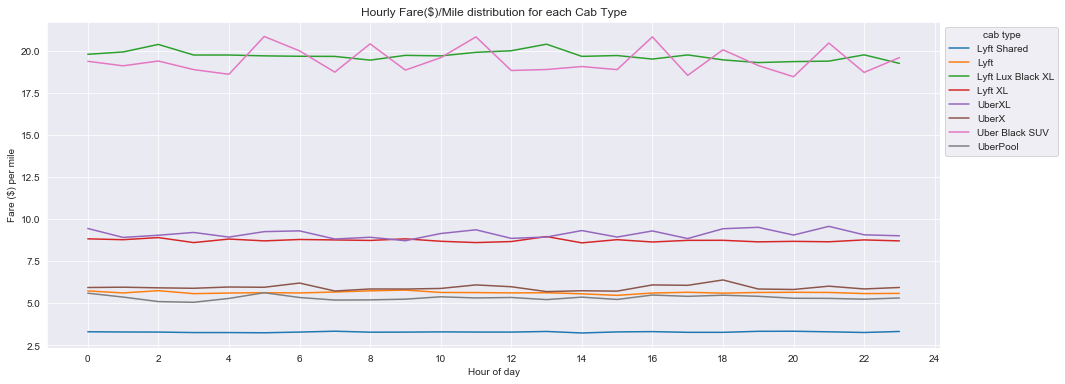

In [28]:
f, axes = plt.subplots (figsize=(16,6))

vis1 = sns.lineplot(x=df2.hour, y=df2.fare_per_mile, data=df2, hue=df2.name,err_style=None)
plt.xticks(range(0, 25,2))
vis1.set(xlabel='Hour of day',ylabel='Fare ($) per mile')
plt.legend(title='cab type', loc='upper left', labels=['Lyft Shared', 'Lyft','Lyft Lux Black XL','Lyft XL',\
                                                     'UberXL','UberX','Uber Black SUV','UberPool'],bbox_to_anchor=(1,1))

axes.set_title('Hourly Fare($)/Mile distribution for each Cab Type')

plt.ioff()

This hourly chart gives us the following info:

Top to bottom:

- First two pair lines: **The average fare for Lyft Lux Black XL has a less deviation with respect to hour of the day compared to Uber Black SUV**
- 2nd line pair: **The average fare per mile for UberXL is more expensive than Lyft XL rides**
- 3rd line pair: **Lyft ordinary ride beats UberX ordinary ride in terms of average fare**
- Final pair: **Lyft Shared ride which average about 3 USD is cheaper than UberPool that averages above 5 USD**

So far, I infer Lyft rides has a better rate compared to Uber for this particular dataset.

### Weather vs Fare

In [29]:
UberOnly.columns

Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperat

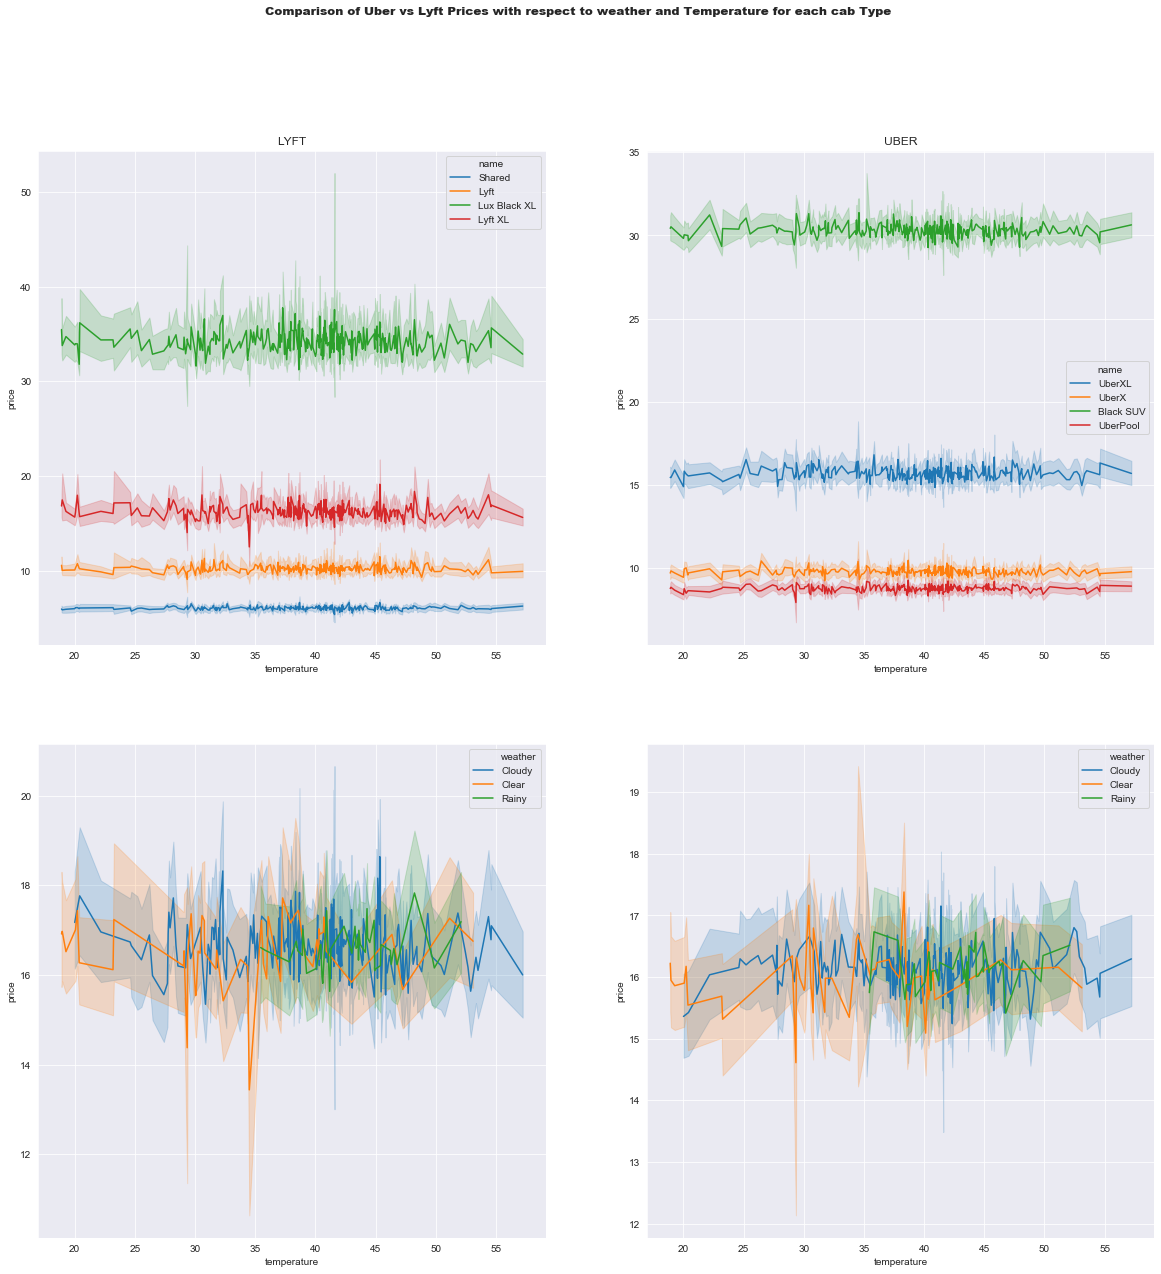

In [30]:
f, axes = plt.subplots (2,2,figsize=(20,20))
vis1 = sns.lineplot(x='temperature',y='price',hue='name',data=LyftOnly,ax=axes[0][0])
vis2 = sns.lineplot(x='temperature',y='price',hue='weather',data=LyftOnly,ax=axes[1][0])
vis3 = sns.lineplot(x='temperature',y='price',hue='name',data=UberOnly,ax=axes[0][1])
vis4 = sns.lineplot(x='temperature',y='price',hue='weather',data=UberOnly,ax=axes[1][1])

plt.suptitle('Comparison of Uber vs Lyft Prices with respect to weather and Temperature for each cab Type',size = 'large',weight = 900)
axes[0][0].set_title("LYFT")
axes[0][1].set_title("UBER")

plt.show()

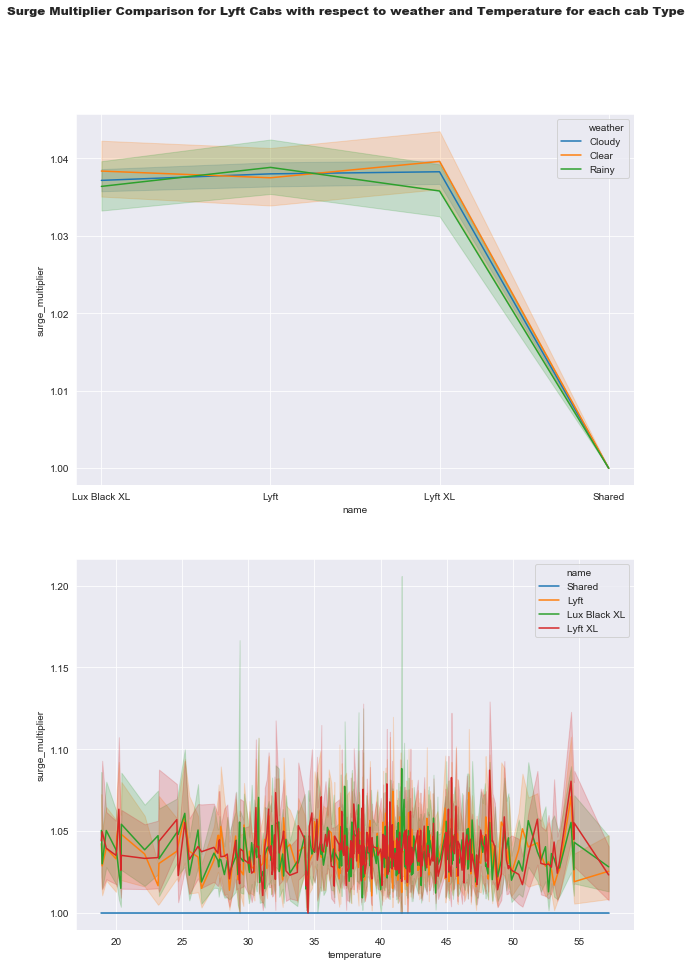

In [31]:
f, axes = plt.subplots (2,1,figsize=(10,15))

vis1 = sns.lineplot(x='name',y='surge_multiplier',hue='weather',data=LyftOnly,ax=axes[0])
vis2 = sns.lineplot(x='temperature',y='surge_multiplier',hue='name',data=LyftOnly,ax=axes[1])
plt.suptitle('Surge Multiplier Comparison for Lyft Cabs with respect to weather and Temperature for each cab Type',size = 'large',weight = 900)
plt.show()


### Data pre-processing
---

Our source dataframe has a lot of redundant variables i.e **Timestamps, ids, Temperature & Apparent temperature**, both have values in each other's proximities, we will eliminate such variable and clear the clutter to a certain extent before we find our best features to be fitted on to the model. 

In [32]:
cab_df = cab_df.drop(['timestamp',
             'latitude',
             'longitude',
             'apparentTemperature',
             'short_summary',
             'long_summary',
             'windGustTime',
             'temperatureHighTime',
             'temperatureLowTime',
             'icon',
             'sunriseTime',
             'sunsetTime',
             'temperatureMinTime',
             'temperatureMaxTime',
             'apparentTemperatureMinTime',
             'apparentTemperatureMaxTime',
             'apparentTemperatureHighTime',
             'apparentTemperatureLowTime',
             'apparentTemperatureMin',
             'apparentTemperatureMax',
             'apparentTemperatureHigh',
             'apparentTemperatureLow',
             'uvIndexTime',
             'product_id',
             'timezone',
             'datetime',
             'id'], axis = 1)

Since we have two use cases: Uber & Lyft, we will segregate the data going forward for our convenience. Let's create two subsets of data, each for Lyft & Uber.

In [33]:
lyft_df = cab_df[cab_df['cab_type'] == 'Lyft']
uber_df = cab_df[cab_df['cab_type'] == 'Uber']

lyft_df.head()

,hour,day,month,source,destination,cab_type,name,price,distance,surge_multiplier,...,windBearing,cloudCover,uvIndex,visibility.1,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,weather
0,9,16,12,Haymarket Square,North Station,Lyft,Shared,5.0,0.44,1.0,...,57,0.72,0,10.000,303.8,0.30,0.1276,39.89,43.68,Cloudy
1,2,27,11,Haymarket Square,North Station,Lyft,Lux,11.0,0.44,1.0,...,90,1.00,0,4.786,291.1,0.64,0.1300,40.49,47.30,Rainy
2,1,28,11,Haymarket Square,North Station,Lyft,Lyft,7.0,0.44,1.0,...,240,0.03,0,10.000,315.7,0.68,0.1064,35.36,47.55,Clear
3,4,30,11,Haymarket Square,North Station,Lyft,Lux Black XL,26.0,0.44,1.0,...,310,0.00,0,10.000,291.1,0.75,0.0000,34.67,45.03,Clear
4,3,29,11,Haymarket Square,North Station,Lyft,Lyft XL,9.0,0.44,1.0,...,303,0.44,0,10.000,347.7,0.72,0.0001,33.10,42.18,Cloudy


In [34]:
uber_df.head()

,hour,day,month,source,destination,cab_type,name,price,distance,surge_multiplier,...,windBearing,cloudCover,uvIndex,visibility.1,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,weather
12,22,30,11,North End,West End,Uber,UberXL,12.0,1.11,1.0,...,281,1.00,0,9.833,281.8,0.79,0.0003,28.79,42.52,Cloudy
13,10,13,12,North End,West End,Uber,Black,16.0,1.11,1.0,...,2,0.03,0,9.831,327.3,0.21,0.0001,18.29,33.83,Clear
14,19,13,12,North End,West End,Uber,UberX,7.5,1.11,1.0,...,76,0.64,0,9.959,330.8,0.21,0.0001,18.29,33.83,Cloudy
15,23,16,12,North End,West End,Uber,WAV,7.5,1.11,1.0,...,57,1.00,0,4.054,325.3,0.30,0.1252,39.22,43.83,Rainy
16,0,14,12,North End,West End,Uber,Black SUV,26.0,1.11,1.0,...,173,0.91,0,10.000,326.7,0.21,0.0001,18.29,33.83,Cloudy


From our EDA and visualizations, we inferred that **Lux & Lux Black** for lyft were the categories that weren't seemingly comparable to Uber's **WAV and Taxi** , also we dont need the **cab_type** anymore as we have segregated our subset already. so we drop them. 


In [35]:
#Lyft
lyft_df.drop(lyft_df[lyft_df['name'] == 'Lux'].index, inplace = True) 
lyft_df.drop(lyft_df[lyft_df['name'] == 'Lux Black'].index, inplace = True) 

#Uber
uber_df.drop(uber_df[uber_df['name'] == 'WAV'].index, inplace = True) 
uber_df.drop(uber_df[uber_df['name'] == 'Taxi'].index, inplace = True) 

lyft_df = lyft_df.drop('cab_type', axis = 1)
uber_df = uber_df.drop('cab_type', axis = 1)

In [36]:
uber_df.columns

Index(['hour', 'day', 'month', 'source', 'destination', 'name', 'price',
       'distance', 'surge_multiplier', 'temperature', 'precipIntensity',
       'precipProbability', 'humidity', 'windSpeed', 'windGust', 'visibility',
       'temperatureHigh', 'temperatureLow', 'dewPoint', 'pressure',
       'windBearing', 'cloudCover', 'uvIndex', 'visibility.1', 'ozone',
       'moonPhase', 'precipIntensityMax', 'temperatureMin', 'temperatureMax',
       'weather'],
      dtype='object')

Variables like **name, weather, source and destination** are strings which needs to be converted to a float/int. We will use Pandas' **get_dummies()** to perform one-hot encoding  

In [37]:
#one-hot encoding for Lyft
lyft_df = pd.get_dummies(lyft_df, columns=['weather','name', 'source', 'destination'])

#one-hot encoding for Uber
uber_df = pd.get_dummies(uber_df, columns=['weather','name', 'source', 'destination'])

### Use case 1: Lyft Price Prediction
---

### Recursive Feature Elimination

Since we have over 50 variables, we have no way to gauge how each variable contributes to predictor, also passing a large number of variable to our model can diminish its performance. Hence, we feel the need to employe RFE for our case. 

In [38]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
 
X = lyft_df.drop(['price'], axis =1)
y = lyft_df[['price']]

names = X.columns

#use linear regression as the model
lr = LinearRegression()

#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=40)
rfe.fit(X,y)

best_features = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))
best_features.columns = ['Ranking','Feature']
best_features

,Ranking,Feature
0,1,destination_Back Bay
1,1,destination_Beacon Hill
2,1,destination_Boston University
3,1,destination_Fenway
4,1,destination_Financial District
5,1,destination_Haymarket Square
6,1,destination_North End
7,1,destination_North Station
8,1,destination_Northeastern University
9,1,destination_South Station


### Train-valid-test split

In [39]:
from sklearn.model_selection import train_test_split

X = lyft_df[['destination_Back Bay','destination_Beacon Hill','destination_Boston University','destination_Fenway',
            'destination_Financial District','destination_Haymarket Square','destination_North End','destination_North Station',
            'destination_Northeastern University','destination_South Station','destination_Theatre District','destination_West End',
            'dewPoint','distance','humidity','moonPhase','name_Lux Black XL','name_Lyft','name_Lyft XL','name_Shared',
            'precipIntensity','precipIntensityMax','precipProbability','source_Back Bay','source_Beacon Hill',
             'source_Boston University','source_Fenway','source_Financial District','source_Haymarket Square',
             'source_North End','source_North Station','source_Northeastern University','source_South Station',
             'source_Theatre District','source_West End','surge_multiplier','temperature','uvIndex','visibility.1']]

y = lyft_df[['price']]

# 70% training and 30% validation + test
X_train_l, X_val_test_l, y_train_l, y_val_test_l = train_test_split(X,y,test_size=0.30)

# 15% validation and 15% test
X_val_l, X_test_l, y_val_l, y_test_l = train_test_split(X_val_test_l, y_val_test_l, test_size=0.50)

print("Training Set:", X_train_l.shape)
print("Validation Set:", X_val_l.shape)
print("Test Set:", X_test_l.shape)

Training Set: (143456, 39)
Validation Set: (30741, 39)
Test Set: (30741, 39)


In [40]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xg_reg1 = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 10, 
                          n_estimators = 10)

xg_reg1.fit(X_train_l, y_train_l, verbose=0)

pred_val_l = xg_reg1.predict(X_val_l)

mae_val_l = mean_absolute_error(pred_val_l,y_val_l)
mse_val_l = mean_squared_error(pred_val_l,y_val_l)
rmse_val_l = np.sqrt(mean_squared_error(pred_val_l,y_val_l))

print('*************************************************************************************')
print('MAE:',mae_val_l )
print('MSE:', mse_val_l)
print('RMSE:', rmse_val_l)
print('*************************************************************************************')

[23:47:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
*************************************************************************************
MAE: 6.137132759087414
MSE: 86.7832351008724
RMSE: 9.315751987943454
*************************************************************************************


### Feature importance

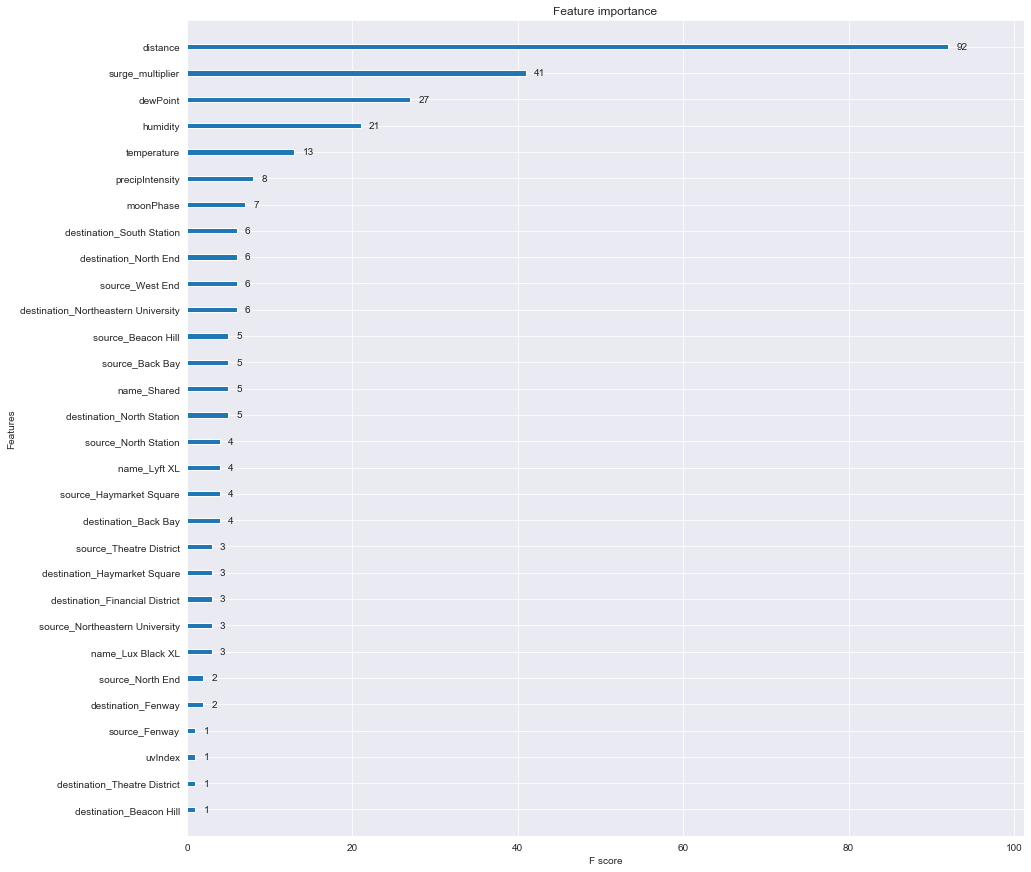

In [41]:
plt.rcParams['figure.figsize'] = [15, 15]
xgb.plot_importance(xg_reg1)
plt.show()

Wow! Of all the 40 predictors, only **distance, surge_multiplier, humidity, dewPoint, moonPhase, temperature** made the cut. Let's try and tune our modedl on our test set to see if the performance improves. 

### Hyperparameter tuning using RandomizedSearchCV()

In [42]:
from sklearn.model_selection import RandomizedSearchCV

params = {'colsample_bytree' :[0.3, 0.5, 0.6, 0.8], 
          'learning_rate' :   [0.1, 0.001, 0.01, 1],
          'max_depth' :       [5,10 , 15], 
          'alpha' :            [10, 15, 20], 
          'n_estimators' :     [10, 15, 20]
         }

random_search = RandomizedSearchCV(estimator=xg_reg1, param_distributions= params, cv = 3 , n_iter= 5, n_jobs= -1)
result = random_search.fit(X_train_l, y_train_l) 

result.best_params_

[23:47:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'n_estimators': 20,
 'max_depth': 10,
 'learning_rate': 1,
 'colsample_bytree': 0.3,
 'alpha': 20}

Next step would be to create a new model and pass the best params as arguments...

In [43]:
xg_reg2 = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = result.best_params_['colsample_bytree'], 
                          learning_rate = result.best_params_['learning_rate'],
                          max_depth = result.best_params_['max_depth'], 
                          alpha = result.best_params_['alpha'], 
                          n_estimators = result.best_params_['n_estimators'])

xg_reg2.fit(X_train_l, y_train_l, verbose=0)

pred_test_l = xg_reg2.predict(X_test_l)


mae_test_l = mean_absolute_error(pred_test_l,y_test_l)
mse_test_l = mean_squared_error(pred_test_l,y_test_l)
rmse_test_l = np.sqrt(mean_squared_error(pred_test_l,y_test_l))

print('*************************************************************************************')
print('MAE:',mae_test_l )
print('MSE:', mse_test_l)
print('RMSE:', rmse_test_l)
print('*************************************************************************************')

[23:47:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
*************************************************************************************
MAE: 1.111975965943195
MSE: 2.459364298235422
RMSE: 1.5682360467210994
*************************************************************************************


### Use case 2: Uber Price Prediction
---

### RFE

In [44]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

X = uber_df.drop(['price'], axis =1)
y = uber_df[['price']]

names = X.columns

#use linear regression as the model
lr = LinearRegression()

#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=40)
rfe.fit(X,y)

best_features = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))
best_features.columns = ['Ranking','Feature']
best_features

,Ranking,Feature
0,1,cloudCover
1,1,destination_Back Bay
2,1,destination_Beacon Hill
3,1,destination_Boston University
4,1,destination_Fenway
5,1,destination_Financial District
6,1,destination_Haymarket Square
7,1,destination_North End
8,1,destination_North Station
9,1,destination_Northeastern University


### Train-Valid-Test

In [45]:
from sklearn.model_selection import train_test_split

X = uber_df[['cloudCover', 'destination_Back Bay','destination_Beacon Hill', 'destination_Boston University','destination_Fenway', 
             'destination_Financial District','destination_Haymarket Square', 'destination_North End','destination_North Station', 
             'destination_Northeastern University','destination_South Station', 'destination_Theatre District','destination_West End', 
             'source_Back Bay', 'source_Beacon Hill','source_Boston University', 'source_Fenway','source_Financial District', 
             'source_Haymarket Square','source_North End', 'source_North Station','source_Northeastern University', 'source_South Station',
             'source_Theatre District', 'source_West End','dewPoint', 'distance', 'humidity','name_Black', 'name_Black SUV',
             'name_UberPool','name_UberX','name_UberXL', 'precipIntensity', 'precipProbability','uvIndex', 'weather_Clear', 
             'weather_Cloudy','windGust','windSpeed']]

y = uber_df[['price']]

# 70% training and 30% validation + test
X_train_u, X_val_test_u, y_train_u, y_val_test_u = train_test_split(X,y,test_size=0.30)

# 15% validation and 15% test
X_val_u, X_test_u, y_val_u, y_test_u = train_test_split(X_val_test_u, y_val_test_u, test_size=0.50)

print("Training Set:", X_train_u.shape)
print("Validation Set:", X_val_u.shape)
print("Test Set:", X_test_u.shape)

Training Set: (192830, 40)
Validation Set: (41321, 40)
Test Set: (41321, 40)


In [46]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xg_reg3 = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 10, 
                          n_estimators = 10)

xg_reg3.fit(X_train_u, y_train_u, verbose=0)

pred_val_u = xg_reg3.predict(X_val_u)

mae_val_u = mean_absolute_error(pred_val_u,y_val_u)
mse_val_u = mean_squared_error(pred_val_u,y_val_u)
rmse_val_u = np.sqrt(mean_squared_error(pred_val_u,y_val_u))

print('*************************************************************************************')
print('MAE:',mae_val_u )
print('MSE:', mse_val_u)
print('RMSE:', rmse_val_u)
print('*************************************************************************************')

[23:48:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
*************************************************************************************
MAE: 6.201809014664976
MSE: 74.14685511581148
RMSE: 8.610856816589827
*************************************************************************************


### Feature importance

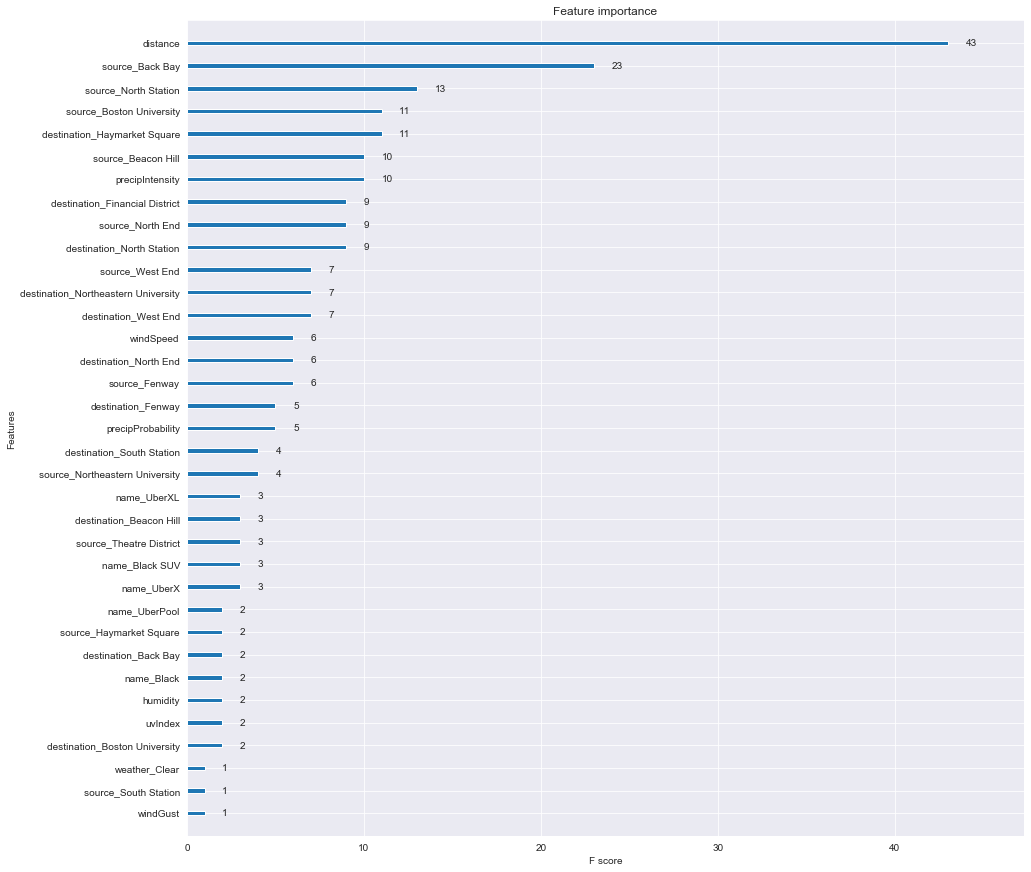

In [47]:
plt.rcParams['figure.figsize'] = [15, 15]
xgb.plot_importance(xg_reg3)
plt.show()

### Hyperparameter tuning using RandomizedSearchCV()

In [48]:
from sklearn.model_selection import RandomizedSearchCV

params = {'colsample_bytree' :[0.3, 0.5, 0.6, 0.8], 
          'learning_rate' :   [0.1, 0.001, 0.01, 1],
          'max_depth' :       [5,10 , 15], 
          'alpha' :            [10, 15, 20], 
          'n_estimators' :     [10, 15, 20]
         }

random_search = RandomizedSearchCV(estimator=xg_reg3, param_distributions= params, cv = 3 , n_iter= 5, n_jobs= -1)
result = random_search.fit(X_train_u, y_train_u) 

result.best_params_

[23:48:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'n_estimators': 10,
 'max_depth': 10,
 'learning_rate': 1,
 'colsample_bytree': 0.6,
 'alpha': 15}

In [49]:
xg_reg4 = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = result.best_params_['colsample_bytree'], 
                          learning_rate = result.best_params_['learning_rate'],
                          max_depth = result.best_params_['max_depth'], 
                          alpha = result.best_params_['alpha'], 
                          n_estimators = result.best_params_['n_estimators'])

xg_reg4.fit(X_train_u, y_train_u, verbose=0)

pred_test_u = xg_reg4.predict(X_test_u)

mae_test_u = mean_absolute_error(pred_test_u,y_test_u)
mse_test_u = mean_squared_error(pred_test_u,y_test_u)
rmse_test_u = np.sqrt(mean_squared_error(pred_test_u,y_test_u))

print('*************************************************************************************')
print('MAE:',mae_test_u )
print('MSE:', mse_test_u)
print('RMSE:', rmse_test_u)
print('*************************************************************************************')

[23:48:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
*************************************************************************************
MAE: 1.242336834986718
MSE: 4.10977909873248
RMSE: 2.0272590112594098
*************************************************************************************


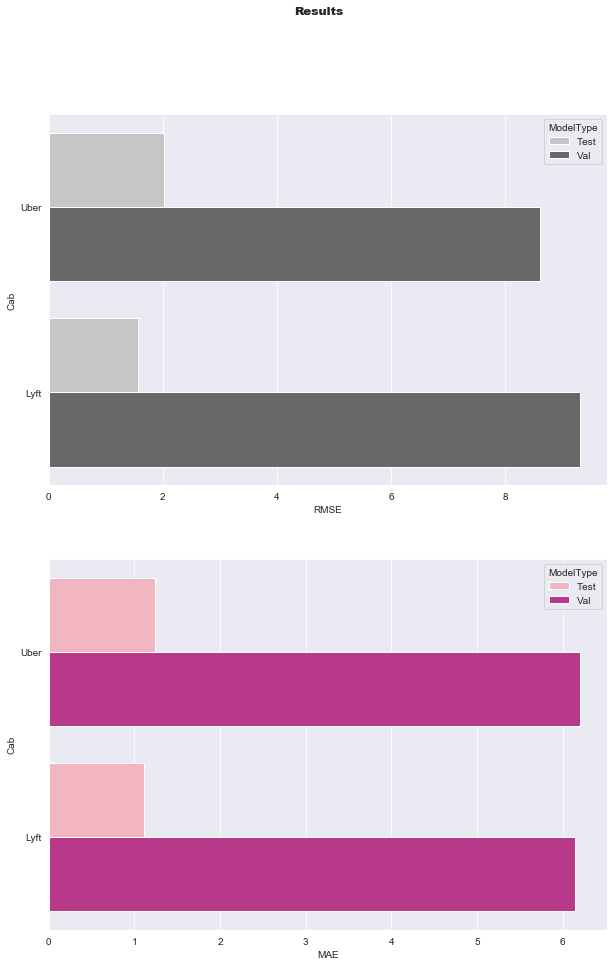

In [50]:
plot_df = pd.DataFrame({"Cab" : ['Uber','Uber','Lyft','Lyft'],
                        "ModelType" : ['Test','Val','Test','Val'],
                        "RMSE" : [rmse_test_u,rmse_val_u,rmse_test_l,rmse_val_l],
                        "MAE" : [mae_test_u,mae_val_u,mae_test_l,mae_val_l] 
                       })

f, axes = plt.subplots (2,1,figsize=(10,15))
vis1 = sns.barplot(y = 'Cab' , x = 'RMSE', data = plot_df , hue = 'ModelType',ax=axes[0],palette='Greys')
vis2 = sns.barplot(y = 'Cab' , x = 'MAE', data = plot_df , hue = 'ModelType',ax=axes[1],palette='RdPu')
plt.suptitle('Results',size = 'large',weight = 900)
plt.show()


This marks the end. That's all from us folks!